In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2

d:\Major_WBC_Project\vtproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Vision Transformer Input Size
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
# Load Dataset
train_dataset = datasets.ImageFolder(root=r"D:\Major_WBC_Project\Combined_Dataset\Train", transform=transform)
val_dataset = datasets.ImageFolder(root=r"D:\Major_WBC_Project\Combined_Dataset\Val", transform=transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [14]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
epochs = 8

In [18]:
torch.cuda.empty_cache()  # Clear unused memory


In [19]:
# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1}/{epochs} Completed, Average Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/8] Batch [1/63] Loss: 1.6543
Epoch [1/8] Batch [2/63] Loss: 1.8473
Epoch [1/8] Batch [3/63] Loss: 1.7229
Epoch [1/8] Batch [4/63] Loss: 1.5518
Epoch [1/8] Batch [5/63] Loss: 1.3084
Epoch [1/8] Batch [6/63] Loss: 1.5304
Epoch [1/8] Batch [7/63] Loss: 1.4448
Epoch [1/8] Batch [8/63] Loss: 1.1830
Epoch [1/8] Batch [9/63] Loss: 1.0218
Epoch [1/8] Batch [10/63] Loss: 1.7020
Epoch [1/8] Batch [11/63] Loss: 0.8126
Epoch [1/8] Batch [12/63] Loss: 1.0268
Epoch [1/8] Batch [13/63] Loss: 1.4588
Epoch [1/8] Batch [14/63] Loss: 1.6652
Epoch [1/8] Batch [15/63] Loss: 1.2391
Epoch [1/8] Batch [16/63] Loss: 1.0195
Epoch [1/8] Batch [17/63] Loss: 0.7510
Epoch [1/8] Batch [18/63] Loss: 1.1500
Epoch [1/8] Batch [19/63] Loss: 0.9753
Epoch [1/8] Batch [20/63] Loss: 0.9186
Epoch [1/8] Batch [21/63] Loss: 1.7269
Epoch [1/8] Batch [22/63] Loss: 1.2902
Epoch [1/8] Batch [23/63] Loss: 1.0846
Epoch [1/8] Batch [24/63] Loss: 0.4803
Epoch [1/8] Batch [25/63] Loss: 0.6355
Epoch [1/8] Batch [26/63] Loss: 0.

In [20]:
# Save Model
torch.save(model.state_dict(), "Combined_Data_vit_model.pth")
print("Model Saved Successfully ✅")

Model Saved Successfully ✅


In [ ]:
# # Load Model Architecture
# model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=4, ignore_mismatched_sizes=True)

# # Load Pretrained Weights
# model.load_state_dict(torch.load("7wbc_Cancer_cells_vit_model.pth"), strict=False)  # strict=False to avoid mismatch issues

# # Push to GPU/CPU
# model.to(device)
# model.eval()

# print("Model loaded successfully ✅")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\anujk\AppData\Local\Temp\ipykernel_19012\1891803847.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only

Model loaded successfully ✅


In [21]:
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

In [22]:
# Validation Accuracy Calculation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 82.67%


In [23]:
# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=train_dataset.classes))


Classification Report:
               precision    recall  f1-score   support

        Baso       1.00      0.90      0.95        30
      Eosino       0.77      0.90      0.83        30
      Lympho       0.92      0.80      0.86        30
        Mono       0.67      0.73      0.70        30
      Neutro       0.83      0.80      0.81        30

    accuracy                           0.83       150
   macro avg       0.84      0.83      0.83       150
weighted avg       0.84      0.83      0.83       150



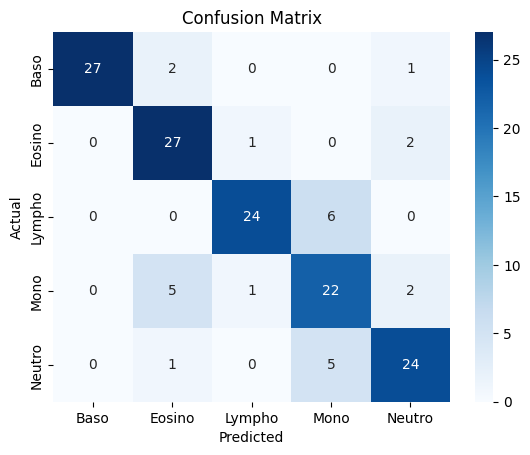

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

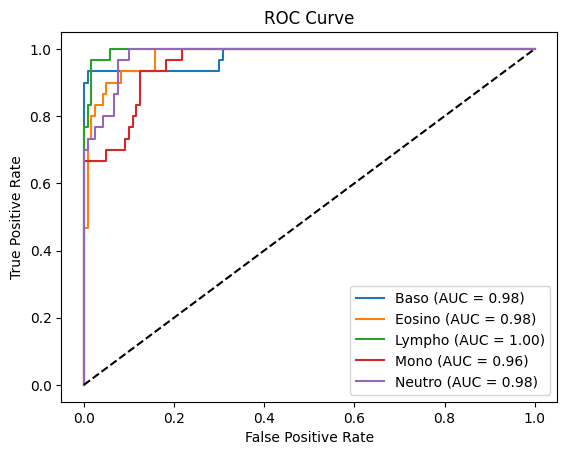

In [25]:
# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{train_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error


In [27]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")

Accuracy: 0.8267
Precision: 0.8378
Recall: 0.8267
F1 Score: 0.8295
RMSE: 0.7303
